<a href="https://colab.research.google.com/github/EddyGiusepe/Neural_Network_from_scratch_only_with_Python/blob/main/1_Rede_Neural_desde_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Rede Neural desde zero</h2>


Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Este Script está baseado no Canal de Youtube de [Pepe Cantoral, PhD](https://www.youtube.com/watch?v=W5HJKWL2i08).


Aqui estudaremos a como programar uma Rede Neural desde Zero (usando apenas Python), sem usar FrameWorks de Deep Learning. Nesta primeira parte implementaremos as funções necessárias para o Forward Pass, como são a Transformação Linear, a função ReLU, Softmax e Cross-Entropy. Depois calcularemos o Gradiente com respeito aos parâmetros da Rede Neural. Finalmente (no seguinte script) implementaremos o Loop de treinamento para que nossa Rede Neural aprenda.

# Rede Neural (2 camadas ou capas)

In [ ]:
# Instalar:
!pip install jupyterthemes

In [2]:
# Importamos nossas bibliotecas

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Somente para usuários de Jupyter Themes
from jupyterthemes import jtplot
jtplot.style(grid=False)

In [3]:
# Importar MNIST
# Ver vídeo para aprender a importar estes Dados: https://www.youtube.com/watch?v=7cMKAlnSmpM

import gzip
import os
from os.path import isfile, join
def list_files(mnist_path):
    return [join(mnist_path,f) for f in os.listdir(mnist_path) if isfile(join(mnist_path, f))]

def get_images(mnist_path):
    for f in list_files(mnist_path):
        if 'train-images' in f:
            with gzip.open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                train_images = data.read()
                x_train = np.frombuffer(train_images, dtype=np.uint8)
                x_train = x_train.reshape((num_images, rows, cols))
        elif 'train-labels' in f:
            with gzip.open(f, 'rb') as data:
                train_labels = data.read()[8:]
                y_train = np.frombuffer(train_labels, dtype=np.uint8)
        if 't10k-images' in f:
            with gzip.open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                test_images = data.read()
                x_test = np.frombuffer(test_images, dtype=np.uint8)
                x_test = x_test.reshape((num_images, rows, cols))
        elif 't10k-labels' in f:
            with gzip.open(f, 'rb') as data:
                test_labels = data.read()[8:]
                y_test = np.frombuffer(test_labels, dtype=np.uint8)
    
    return x_train, y_train, x_test, y_test        

In [4]:
# Aqui passamos o caminho: MNIST path
# Obviamente os Dados já foram baixados com antecedencia

mnist_path = '/content/drive/MyDrive/2_DEEP_LEARNING_REDES_NEURAIS_Jorge/1_Pytorch_Deep_Learning/Pytorch_examples/Rede_neural_exemplo_Pytorch/data/MNIST/raw/mnist_raw'

In [5]:
# Aqui utilizamos a função "get_images()" 

x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

In [6]:
# Temos imagens de 28x28
x_train_num.shape

(60000, 28, 28)

In [7]:

y_train_num.shape

(60000,)

# Converter as imagens em vetores e a float32

In [8]:
# Aquí dividimos nuestros Datos en train, val y test
# También los convertimos a vectores

# (50000, -1) --> Vai ter 50000 linhas e 28x28== -1. Assim: shape(50000, 28x28==-1)
x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)/255 # /255 --> significa que ta sendo NORMALIZADO entre (0, 1)
y_train = y_train_num[:50000].reshape(50000, 1)

# Validation (aqui teremos 10000)
x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)/255
y_val = y_train_num[50000:].reshape(10000, 1)

# Para teste
x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)/255
y_test = y_test_num.copy().reshape(10000, 1)

In [9]:
# Obvio que o valor MÁXIMO do set de treinamento é 1, porque está normalizado

x_train.max()

1.0

In [10]:
# 28x28 = 784
x_train.shape

(50000, 784)

In [11]:
print(x_train.shape) # Dados das imagens
print(y_train.shape) # Dados das etiquetas

print(x_val.shape)
print(y_val.shape)
      
print(x_test.shape)
print(y_test.shape)      

(50000, 784)
(50000, 1)
(10000, 784)
(10000, 1)
(10000, 784)
(10000, 1)


# Graficamos algumas imagens

In [12]:
def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()
    

A imagem printada representa un: [5]


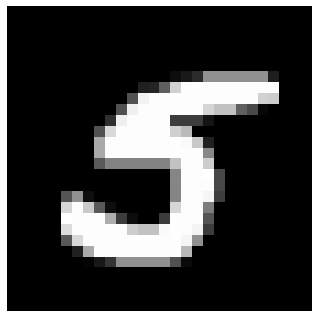

In [13]:
rnd_idx = np.random.randint(len(y_test))
print(f'A imagem printada representa un: {y_test[rnd_idx]}')
plot_number(x_test_num[rnd_idx])


Em nosso caso temos APENAS UMA CAMADA OCULTA (hidden). Mas o Gif a seguir representa muito bem a nossa ideia. Essa camada oculta terá (em nosso caso) $200$ neurônios.

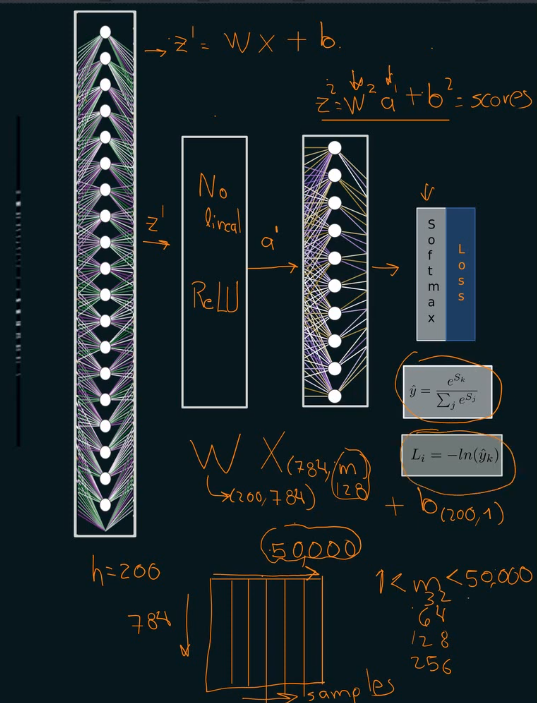

![](https://miro.medium.com/max/1400/1*8jI3wB41kYxP-Wo5rO_Yvg.gif)

Nosso modelo usará as seguintes equações:

$$z^1 = W^1 X  + b^1$$

$$a^1 = ReLU(z^1)$$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j e^{z_j}}$$

$$\mathcal{L}(\hat{y}^i, y^i) = - y^i ln(\hat{y}^i) = - ln(\hat{y}^i)$$

$$\mathcal{J}(w, b) = \frac{1}{num_samples} \sum_{i=1}^{num_samples}- ln(\hat{y}^i)$$


# Rede Neural - Duas capas 200 - 10 
# Criar 'Mini-batches'

In [14]:
# Extraímos o número de elementos
x_train.shape[0]

50000

In [15]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x --> #muestras, 784
    y --> #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Errona quantidade de amostras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Parâmetros de inicialização

In [16]:
def init_parameters(input_size, neurons):
    
    '''
    input_size -> N° de elementos de entrada, 784
    neurons -> list [200, 10] quantidade de neuronas em cada camada
    '''
    
    W1 = np.random.randn(neurons[0], input_size) * 0.001 # N° de neurônios, 784  
    b1 = np.zeros((neurons[0], 1)) # N° de neurônios, 1
    
    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001
    b2 = np.zeros((neurons[1], 1))
    
    return {'W1': W1, 'b1':b1, 'W2':W2, 'b2':b2}

In [17]:
# Verificando nossos parâmetros

parameters = init_parameters(28*28, [200, 10])
print(parameters['W1'].shape)
print(parameters['W2'].shape)
print(parameters['b2'].shape)

(200, 784)
(10, 200)
(10, 1)


In [18]:
def relu(x):
    return np.maximum(0, x)
    

In [19]:
def scores(x, parameters, activation_fcn): # Antes se chamava --> def linear_pass()
    '''
    x tiene la forma (#pixeles, num samples)
    '''
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fcn(z1) # Devolve a função de Ativação
    z2 = parameters['W2'] @ a1 + parameters['b2']
    
    return z2, z1, a1

In [20]:
#scores, z1, a1 = scores(x_train[:64].T, parameters, relu) 

In [21]:
# Podemo verificar o shape

#x_train[:64].shape

In [22]:
# Por isso que aplicamos a TRANSPOSTA

#x_train[:64].T.shape

In [23]:

#scores.shape

In [24]:
def softmax(x):
  '''
  Ver acima a forma matemática da função de Ativação SOFTMAX
  '''
  exp_scores = np.exp(x)
  sum_exp_scores = np.sum(exp_scores, axis=0) # A soma é feita nas COLUNAS axis=0 
  probs = exp_scores/sum_exp_scores
  return probs

In [25]:
# Agora definimos a função de Perda: CROSS ENTROPY

def x_entropy(scores, y, batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)] # predição de nosso modelo
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    return probs, cost

In [26]:
# Função de Retroprapagação

def backward(probs, x, y, z1, a1, scores, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
    dz2 = probs.copy()
    
    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis =1, keepdims=True) / batch_size
    da1 = parameters['W2'].T @ dz2
    
    dz1 = da1.copy()
    dz1[z1 <= 0 ] =0
    
    dW1 = dz1 @ x 
    db1 = np.sum(dz1, axis=1, keepdims=True) 
    
    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'
    
    grads = {'w1':dW1,  'b1':db1, 'W2':dW2, 'b2':db2}
    
    return grads

In [27]:
# Verificando nossas funções
#y_hat, cost = x_entropy(scores, y_train[:64])

In [28]:

#y_hat.shape

In [29]:
#cost

In [30]:

#grads = backward(y_hat, x_train[:64], y_train[:64],z1, a1, scores, parameters)

In [31]:
def accuracy(x_data, y_data, mb_size=64):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        scores2, z1, a1 = scores(x.T, parameters, relu)
        y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
        
        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]
    return correct/total

In [34]:
# Função para treinar nossa Rede Neural

def train(epochs, parameters, mb_size=64, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores2, z1, a1 = scores(x.T, parameters=parameters, activation_fcn=relu)
            y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
            grads = backward(y_hat, x, y, z1, a1, scores2, parameters, batch_size=len(x))
            
            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']
            
        print(f'costo es: {cost}, y accuracy: {accuracy(x_val, y_val, mb_size)}')
    return parameters

In [35]:
mb_size = 512
learning_rate = 1e-2
epochs = 20

parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)

costo es: 0.4237413851756732, y accuracy: 0.9042
costo es: 0.33404270986387247, y accuracy: 0.9131
costo es: 0.34483559512326434, y accuracy: 0.9224
costo es: 0.33588109781860903, y accuracy: 0.9304
costo es: 0.29510428206759914, y accuracy: 0.9337
costo es: 0.23829089842298815, y accuracy: 0.9396
costo es: 0.163535496369764, y accuracy: 0.945
costo es: 0.20236776328635733, y accuracy: 0.9494
costo es: 0.35661308853151835, y accuracy: 0.9517
costo es: 0.2908856540441645, y accuracy: 0.954
costo es: 0.24073274914348694, y accuracy: 0.9549
costo es: 0.11037393713660368, y accuracy: 0.9591
costo es: 0.14021103198965978, y accuracy: 0.9598
costo es: 0.14126766300485266, y accuracy: 0.9614
costo es: 0.1721178695956196, y accuracy: 0.962
costo es: 0.08634564035036472, y accuracy: 0.964
costo es: 0.07911751697022591, y accuracy: 0.9636
costo es: 0.1042929074247853, y accuracy: 0.9656
costo es: 0.09595606327396008, y accuracy: 0.9671
costo es: 0.10884065506381872, y accuracy: 0.9678


In [36]:

accuracy(x_train, y_train, mb_size)

0.97136

In [37]:
# Com Dados que a REDE nunca viu

accuracy(x_test, y_test, mb_size)

0.9657

In [47]:
def predict(x): 
  '''
  x --> recebe uma imagem
  '''
  scores2, _, _ = scores(x, parameters, relu) # Aqui não me interessa z1 nem a1, só nos interessa os scores
  return np.argmax(scores2)

In [48]:
x_test[0].shape

(784,)

In [45]:
# Queremos que seja (784,1), por isso aplicamos o seguinte
x_test[0].reshape(-1, 1).shape

(784, 1)

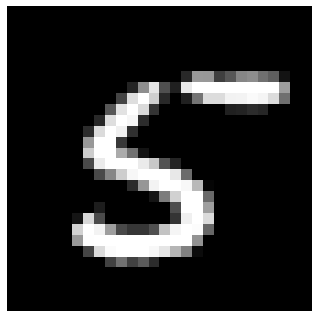

el valor predicho es: 5


In [70]:
idx = np.random.randint(len(y_test))

plot_number(x_test_num[idx])
pred = predict(x_test[idx].reshape(-1, 1))
print(f'O valor predito é: {pred}')